In [1]:
import cpi
import matplotlib.pyplot as plt
import pandas as pd
import os
from dotenv import load_dotenv
import requests
import json

In [2]:
#cpi.update()
load_dotenv("../../.env",override=True)
pd.set_option("display.max_columns",500)

In [3]:
consumerKey = os.environ.get("CONSUMER_KEY")



In [4]:
url = "https://api.tdameritrade.com/v1/marketdata/$SPX.X/pricehistory?periodType=year&period=20&frequencyType=monthly&frequency=1"
response = requests.get(url,
        params={'apikey' : consumerKey})
SPY = pd.DataFrame(json.loads(response.content)['candles'])
SPY['date'] = pd.to_datetime(SPY['datetime'],unit='ms').dt.date
SPY.index = SPY['date'].values
SPY['YOY'] =  SPY['close']/SPY['close'].shift(12) - 1
SPY['YOY_shift-2'] = SPY['YOY'].shift(-2)

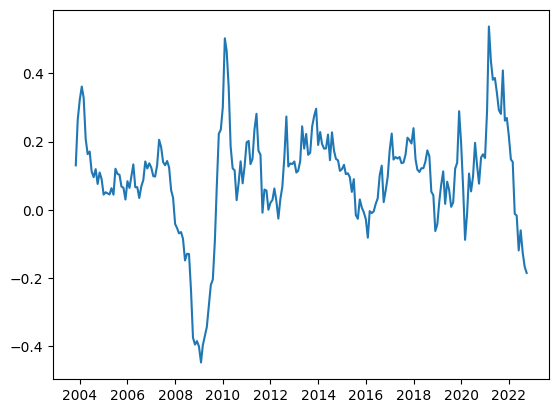

In [5]:
plt.plot(SPY['YOY'])

In [6]:
college = cpi.series.get(items='College tuition and fees',periodicity='Monthly').to_dataframe().sort_values(by='date')
housing = cpi.series.get(items='Housing',periodicity='Monthly').to_dataframe().sort_values(by='date')
allItems = cpi.series.get(items='All items',periodicity='Monthly').to_dataframe().sort_values(by='date')
energy = cpi.series.get(items='Energy',periodicity='Monthly').to_dataframe().sort_values(by='date')
food = cpi.series.get(items='Food',periodicity='Monthly').to_dataframe().sort_values(by='date')
medicalCare = cpi.series.get(items='Medical care',periodicity='Monthly').to_dataframe().sort_values(by='date')
recreation = cpi.series.get(items='Recreation',periodicity='Monthly').to_dataframe().sort_values(by='date')
rent = cpi.series.get(items='Rent of primary residence',periodicity='Monthly').to_dataframe().sort_values(by='date')
healthInsurance = cpi.series.get(items='Health insurance',periodicity='Monthly').to_dataframe().sort_values(by='date')


In [7]:
series = {
    'college':college,
    'housing':housing,
    'allItems':allItems,
    'energy':energy,
    'food':food,
    'medicalCare':medicalCare,
    'recreation':recreation,
    'rent':rent,
    'healthInsurance':healthInsurance,
}


In [8]:
for k in series.keys():
    series[k] = series[k][series[k]['period_type']=='monthly'][['year','date','value','series_id','series_items_name']].copy()
    series[k]['inflation'] = series[k]['value']/series[k]['value'].shift(12) - 1
    series[k].index = pd.to_datetime(series[k]['date']).values
    

In [9]:
series['housing']

,year,date,value,series_id,series_items_name,inflation
1967-01-01,1967,1967-01-01,30.500,CUUR0000SAH,Housing,NaN
1967-02-01,1967,1967-02-01,30.500,CUUR0000SAH,Housing,NaN
1967-03-01,1967,1967-03-01,30.500,CUUR0000SAH,Housing,NaN
1967-04-01,1967,1967-04-01,30.600,CUUR0000SAH,Housing,NaN
1967-05-01,1967,1967-05-01,30.700,CUUR0000SAH,Housing,NaN
...,...,...,...,...,...,...
2022-04-01,2022,2022-04-01,295.259,CUUR0000SAH,Housing,0.064925
2022-05-01,2022,2022-05-01,297.868,CUUR0000SAH,Housing,0.068976
2022-06-01,2022,2022-06-01,300.927,CUUR0000SAH,Housing,0.073336
2022-07-01,2022,2022-07-01,302.327,CUUR0000SAH,Housing,0.073589


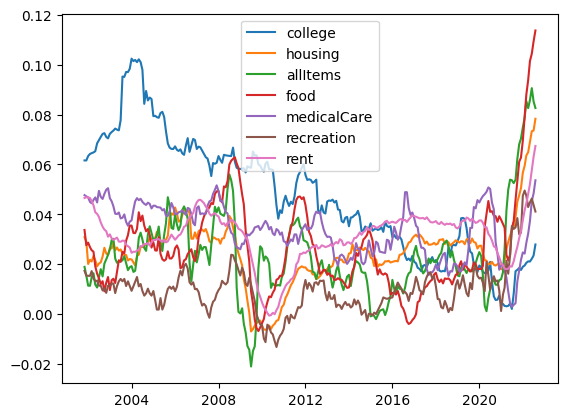

In [10]:
for k in ['college', 'housing', 'allItems', 'food',
    'medicalCare', 'recreation', 'rent']:
    plt.plot(series[k]['inflation'].tail(250),label=k)
plt.legend()
plt.show()

In [11]:
SPY['date']=SPY['date'].astype(str)

In [13]:
allDat = pd.concat(list(series.values()))
allDat['date']=allDat['date'].astype(str)


In [14]:
inflation_cross = pd.crosstab(index = allDat['date'],
    columns = allDat['series_items_name'],
    values = allDat['inflation'],
    aggfunc='mean')

In [35]:
merge = SPY[['date','close','YOY','YOY_shift-2']].merge(inflation_cross,
    on = 'date',how='inner').dropna()

In [17]:
merge.corr()

C:\Users\jliv\AppData\Local\Temp\ipykernel_25068\2247061968.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merge.corr()


,close,YOY,YOY_shift-2,All items,College tuition and fees,Energy,Food,Health insurance,Housing,Medical care,Recreation,Rent of primary residence
close,1.000000,0.363642,0.272803,0.489763,-0.850441,0.327664,0.300732,0.219189,0.633262,-0.326249,0.639212,0.329917
YOY,0.363642,1.000000,0.815587,0.195754,-0.380855,0.387392,-0.292942,-0.098260,-0.051446,-0.275861,-0.181104,-0.325383
YOY_shift-2,0.272803,0.815587,1.000000,-0.046415,-0.369799,0.139231,-0.442461,-0.089462,-0.224100,-0.265346,-0.269803,-0.392011
All items,0.489763,0.195754,-0.046415,1.000000,-0.148680,0.910683,0.686836,0.084712,0.715162,0.005336,0.638737,0.261170
College tuition and fees,-0.850441,-0.380855,-0.369799,-0.148680,1.000000,-0.082185,0.050304,-0.146776,-0.369881,0.369701,-0.354721,-0.192236
Energy,0.327664,0.387392,0.139231,0.910683,-0.082185,1.000000,0.429986,-0.109392,0.450756,-0.064407,0.356678,-0.022845
Food,0.300732,-0.292942,-0.442461,0.686836,0.050304,0.429986,1.000000,0.198541,0.648861,0.168502,0.653031,0.388293
Health insurance,0.219189,-0.098260,-0.089462,0.084712,-0.146776,-0.109392,0.198541,1.000000,0.349336,0.621698,0.256447,0.519344
Housing,0.633262,-0.051446,-0.224100,0.715162,-0.369881,0.450756,0.648861,0.349336,1.000000,-0.017819,0.761751,0.813018
Medical care,-0.326249,-0.275861,-0.265346,0.005336,0.369701,-0.064407,0.168502,0.621698,-0.017819,1.000000,-0.051535,0.191881


In [36]:
merge.index = pd.to_datetime(merge['date']).values

In [37]:
merge

,date,close,YOY,YOY_shift-2,All items,College tuition and fees,Energy,Food,Health insurance,Housing,Medical care,Recreation,Rent of primary residence
2006-12-01,2006-12-01,1418.30,0.136194,0.098512,0.025407,0.069805,0.028889,0.021255,0.064000,0.032779,0.035627,0.010027,0.043084
2007-01-01,2007-01-01,1438.24,0.123555,0.097299,0.020756,0.066209,-0.031309,0.024276,0.079681,0.030285,0.042519,0.010118,0.044844
2007-02-01,2007-02-01,1406.82,0.098512,0.131053,0.024152,0.067145,-0.010456,0.030928,0.087955,0.033302,0.043231,0.008838,0.045754
2007-03-01,2007-03-01,1420.86,0.097299,0.205127,0.027788,0.066886,0.044162,0.033005,0.091572,0.033681,0.040060,0.005823,0.045861
2007-04-01,2007-04-01,1482.37,0.131053,0.183554,0.025737,0.065557,0.029121,0.036758,0.097471,0.033917,0.040409,0.003429,0.045222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,2022-04-01,4131.93,-0.011777,-0.119167,0.082586,0.021159,0.302698,0.093819,0.104022,0.064925,0.032273,0.042924,0.048182
2022-05-01,2022-05-01,4132.15,-0.017117,-0.060285,0.085815,0.021093,0.345978,0.101476,0.137605,0.068976,0.037353,0.044811,0.052159
2022-06-01,2022-06-01,3785.38,-0.119167,-0.125518,0.090598,0.022193,0.416239,0.104397,0.172919,0.073336,0.045370,0.046312,0.057769
2022-07-01,2022-07-01,4130.29,-0.060285,-0.167594,0.085248,0.023503,0.329277,0.109321,0.206208,0.073589,0.048344,0.043786,0.063073


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


In [66]:
feats = ['All items',
       'College tuition and fees', 'Energy', 'Food', 'Health insurance',
       'Housing', 'Medical care', 'Recreation', 'Rent of primary residence']
kpi = 'YOY_shift-2'

X, y = merge[feats],merge[kpi]

X_train,X_test,y_train,y_test =  train_test_split(
    X, y, test_size=0.10, random_state=42,shuffle=False)

In [67]:
pipe = Pipeline(
    steps = [('scaler',MinMaxScaler()),
    ('LinearRegression',XGBRegressor())]
)


In [68]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('LinearRegression',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [69]:
pred = pipe.predict(merge[feats])

In [70]:
merge['pred'] = pred

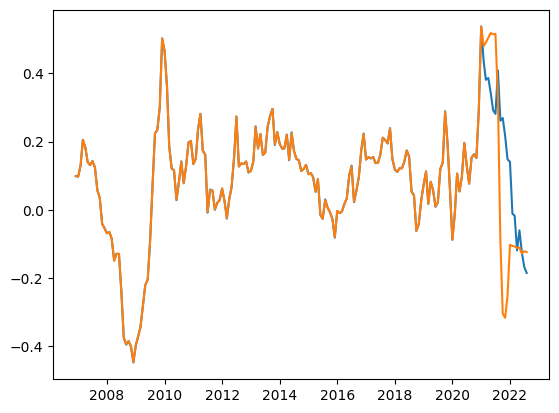

In [71]:
plt.plot(merge[kpi])
plt.plot(merge['pred'])

In [73]:
merge

,date,close,YOY,YOY_shift-2,All items,College tuition and fees,Energy,Food,Health insurance,Housing,Medical care,Recreation,Rent of primary residence,pred
2006-12-01,2006-12-01,1418.30,0.136194,0.098512,0.025407,0.069805,0.028889,0.021255,0.064000,0.032779,0.035627,0.010027,0.043084,0.098500
2007-01-01,2007-01-01,1438.24,0.123555,0.097299,0.020756,0.066209,-0.031309,0.024276,0.079681,0.030285,0.042519,0.010118,0.044844,0.097640
2007-02-01,2007-02-01,1406.82,0.098512,0.131053,0.024152,0.067145,-0.010456,0.030928,0.087955,0.033302,0.043231,0.008838,0.045754,0.131657
2007-03-01,2007-03-01,1420.86,0.097299,0.205127,0.027788,0.066886,0.044162,0.033005,0.091572,0.033681,0.040060,0.005823,0.045861,0.204547
2007-04-01,2007-04-01,1482.37,0.131053,0.183554,0.025737,0.065557,0.029121,0.036758,0.097471,0.033917,0.040409,0.003429,0.045222,0.182309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,2022-04-01,4131.93,-0.011777,-0.119167,0.082586,0.021159,0.302698,0.093819,0.104022,0.064925,0.032273,0.042924,0.048182,-0.111790
2022-05-01,2022-05-01,4132.15,-0.017117,-0.060285,0.085815,0.021093,0.345978,0.101476,0.137605,0.068976,0.037353,0.044811,0.052159,-0.110637
2022-06-01,2022-06-01,3785.38,-0.119167,-0.125518,0.090598,0.022193,0.416239,0.104397,0.172919,0.073336,0.045370,0.046312,0.057769,-0.127939
2022-07-01,2022-07-01,4130.29,-0.060285,-0.167594,0.085248,0.023503,0.329277,0.109321,0.206208,0.073589,0.048344,0.043786,0.063073,-0.121796


In [74]:
cpi_cross = pd.crosstab(index = allDat['date'],
    columns = allDat['series_items_name'],
    values = allDat['value'],
    aggfunc='mean')

In [75]:
cpi_merge = SPY[['date','close']].merge(cpi_cross,
    on = 'date',how='inner').dropna()

In [81]:
for i in cpi_merge.columns:
    try:
        cpi_merge[i] = cpi_merge[i]/cpi_merge[i].values[0]
    except:
        pass

In [83]:
cpi_merge['market/cpi'] = cpi_merge['close']/cpi_merge['All items']

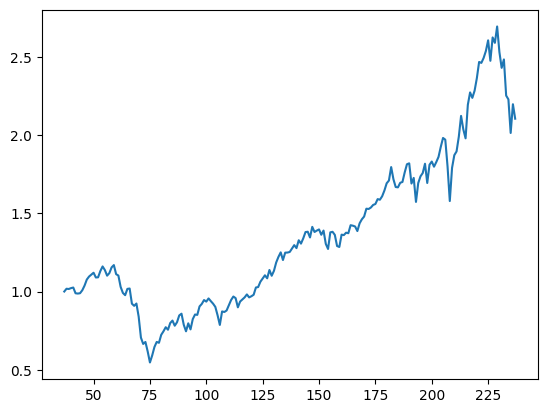

In [85]:

plt.plot(cpi_merge['market/cpi'])

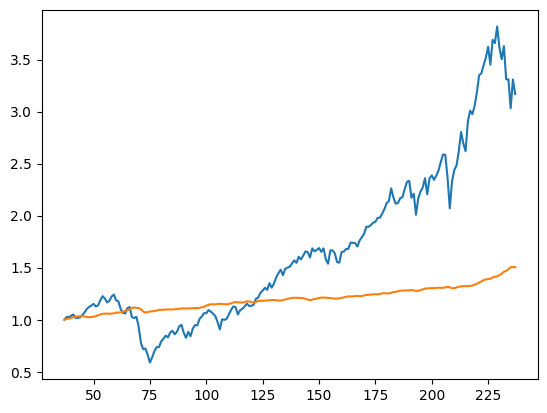

In [86]:
plt.plot(cpi_merge['close'])
plt.plot(cpi_merge['All items'])

In [ ]:
plt.plot(cpi_merge[''])